In [7]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split


# Raw data

In [8]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


In [93]:
use_rows = raw['shot_made_flag'].notnull()
usage_set = raw[use_rows]
compete_set = raw[pandas.isna(raw['shot_made_flag'])]

# FIXME:
#compete_set = raw[raw['shot_made_flag'] == numpy.nan]
#other =  raw[not where_validation]

usage_set[:10]

# FIXME: test with different test/train splits
seed = 1
test_size = 0.3
training, testing = train_test_split(usage_set, test_size=test_size, random_state=seed)

assert compete_set['shot_id'].shape[0] == 5000
assert compete_set['shot_id'].values[0] == 4
assert compete_set['shot_id'].values[-1] == 30693

training[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
5862,Layup,0,0,4,1,0,2004-05,34,0,1.0,2PT Field Goal,Center(C),Less Than 8 ft.,DET,6983
20287,Jump Shot,108,5,8,2,0,1997-98,34,10,1.0,2PT Field Goal,Right Side(R),8-16 ft.,DAL,24213


count    14487.000000
mean        13.507075
std          9.335624
min          0.000000
25%          5.000000
50%         15.000000
75%         21.000000
max         79.000000
Name: shot_distance, dtype: float64


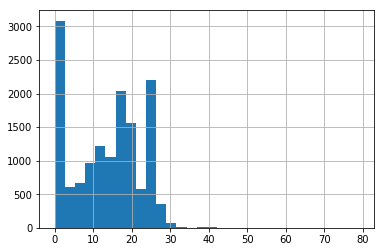

In [36]:
print(training['shot_distance'].describe())

training['shot_distance'].hist(bins=30)

In [94]:
labelencoder = sklearn.preprocessing.OneHotEncoder()

X = training['shot_distance'].reshape(-1, 1)
Y = labelencoder.fit_transform(training['shot_made_flag'].reshape(-1,1)).todense()

model = PLSRegression(n_components=1)
model.fit(X, Y)

X_test = testing['shot_distance'].reshape(-1, 1)
Y_test = testing['shot_made_flag'].astype(numpy.bool)
Y_pred = model.predict(X_test).argmax(axis=1)

Y_pred.shape, Y_test.shape
Y_pred[0:10], Y_test.values[0:10]

# classification accuracy
a = sklearn.metrics.accuracy_score(Y_test, Y_pred)
a

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


0.5977455716586151

In [98]:
X_comp = compete_set['shot_distance'].reshape(-1, 1)
Y_comp = model.predict(X_comp).argmax(axis=-1)

out = compete_set.copy()
out['shot_made_flag'] = Y_comp.astype(numpy.float)
out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


### Features
Shot type. Categorical
Location on court. How is organized?
Shot distance
Minutes/seconds remaining. In the period? (4x12 min)
Period
Season
Point 
Opponent

### Target

Where predictions are removed (nAn) is the validation data

Is there any pattern here that can be exploited?


## Modelling

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR

TODO

* check existing Kaggle competitions, good performing algorithms
* setup sklearn pipeline
* setup Grid search
* format Kaggle submission

Trips & tricks

* LabelEncoder. Categoical data. Ordinal (orderable) versus nominal (not orderable)
